<!-- 
versions
- v1: two Conv2D
- v2: two Conv2D with l2 regularization
- v3: one Conv1D, two Conv2D
- v4: one Conv1D, one Conv2D
re-run
- v5: two Conv2D
- v6: two Conv2D with l2 regularization
- v7: one Conv1D, two Conv2D
- v8: one Conv1D, two Conv2D with l2 regularization
-->
versions
- v1: two Conv2D
- v2: two Conv2D with l2 regularization
- v3: one Conv1D, two Conv2D
- v4: one Conv1D, two Conv2D with l2 regularization

# Setup

In [90]:
!pip install -q biopython

In [91]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/My Drive/data/histone/'
LOG_DIR = '/content/drive/My Drive/dna-nn/histone/'

# module auto reload
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# copy modules
!cp -r '/content/drive/My Drive/dna_nn' .
!ls dna_nn

download.py  load.py  __pycache__


In [93]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

from dna_nn.load import read_fasta, encode, encoded_shape, gen_from_arrays

In [94]:
files = ['H3',      'H4',      'H3K9ac',  'H3K14ac',  'H4ac',
         'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K36me3', 'H3K79me3']
files = [DATA_DIR + file + '.fasta' for file in files]

In [95]:
pd.read_html('http://www.jaist.ac.jp/~tran/nucleosome/members.htm', header=0)[1]

,Datasets,#positive,#negative,Description
0,H3,7667,7298,H3 occupancy
1,H4,6480,8121,H4 occupancy
2,H3K9ac,15415,12367,H3K9 acetylation relative to H3
3,H3K14ac,18771,14277,H3K14 acetylation relative to H3
4,H4ac,18410,15685,H4 acetylation relative to H3
5,H3K4me1,17266,14411,H3K4 monomethylation relative to H3
6,H3K4me2,18143,12540,H3K4 dimethylation relative to H3
7,H3K4me3,19604,17195,H3K4 trimethylation relative to H3
8,H3K36me3,18892,15988,H3K36 trimethylation relative to H3
9,H3K79me3,15337,13500,H3K79 trimethylation relative to H3


# Create dataset

In [88]:
# load
sequences, labels = read_fasta(files[0])
gen = gen_from_arrays(sequences, labels, encode(1, 2))

14963 samples loaded


In [89]:
# split
test_size = 0.15
val_size = 0.15

split_options = dict(test_size=test_size, stratify=labels, random_state=3264)
x_train_val, x_test, y_train_val, y_test = train_test_split(sequences, labels, **split_options)
# normalize val_size and update options
split_options.update(dict(test_size=val_size/(1-test_size), stratify=y_train_val))
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, **split_options)
del x_train_val, y_train_val
print('train size:', len(x_train))
print('test size: ', len(x_val))
print('val size:  ', len(x_test))

train size: 10473
test size:  2245
val size:   2245


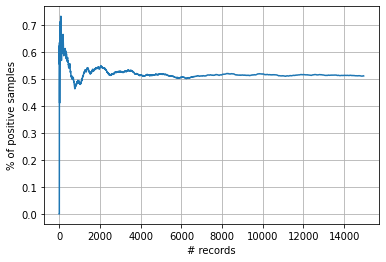

In [8]:
def class_distribution(labels):
    y = pd.Series(labels)
    positive_pctg = y.cumsum() / y.index
    ax = positive_pctg.plot()
    ax.set_xlabel('# records')
    ax.set_ylabel('% of positive samples')
    ax.grid()

class_distribution(labels)

In [96]:
# generators
word_size = 3
region_size = 0

encode_func = encode(word_size, region_size)
x_shape = encoded_shape(sequences[0], word_size, region_size)

train_gen = gen_from_arrays(x_train, y_train, encode_func)
val_gen = gen_from_arrays(x_val, y_val, encode_func)
test_gen = gen_from_arrays(x_test, y_test, encode_func)

# datasets
batch_size = 32
prefetch = tf.data.experimental.AUTOTUNE

output_shapes = (x_shape, ())
output_types = (tf.float32, tf.float32)

train_ds = Dataset.from_generator(train_gen, output_types, output_shapes)
train_ds = train_ds.shuffle(500).batch(batch_size).prefetch(prefetch)

test_ds = Dataset.from_generator(test_gen, output_types, output_shapes)
test_ds = test_ds.batch(batch_size).prefetch(prefetch)

print('x shape:', train_ds.element_spec[0].shape)
print('y shape:', train_ds.element_spec[1].shape)

x shape: (None, 498, 64, 1)
y shape: (None,)


In [97]:
x_val_encode, y_val_encode = [], []
for x, y in val_gen():
    x_val_encode.append(x)
    y_val_encode.append(y)
x_val_encode = np.array(x_val_encode)
y_val_encode = np.array(y_val_encode)
validation_data = (x_val_encode, y_val_encode)

# Build model

In [120]:
keras.backend.clear_session()

kernel_regularizer=keras.regularizers.l2(0.025)

model = keras.Sequential([
    keras.layers.Conv2D(16, (x_shape[0] - x_shape[1] + 1, 1), activation='relu', input_shape=x_shape),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, activation='relu', kernel_regularizer=kernel_regularizer),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=kernel_regularizer),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=kernel_regularizer),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        6976      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [ ]:
version = 'v5'

callbacks = [
    # keras.callbacks.CSVLogger(LOG_DIR + f'{version}.csv'),
    # keras.callbacks.TensorBoard(log_dir=LOG_DIR + f'log/{version}/'),
    # keras.callbacks.LambdaCallback(
    #     on_epoch_end=lambda epoch, logs: gc.collect(),
    #     on_train_end=lambda logs: model.save(LOG_DIR + f'{version}.h5')
    # ),
]

history = model.fit(train_ds, validation_data=validation_data, epochs=40,
                    callbacks=callbacks, verbose=2)

In [86]:
model.evaluate(test_ds)

71/71 [==============================] - 3s 38ms/step - loss: 0.5975 - accuracy: 0.7568


[0.5975359678268433, 0.7567928433418274]

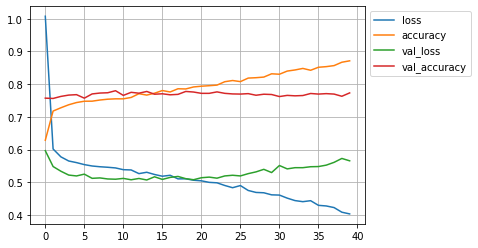

In [87]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()